In [1]:
import pandas as pd
import numpy as np

def describe_df(df):
    """
    Devuelve un resumen completo del DataFrame incluyendo:
    - Tipo de dato
    - Número de nulos
    - Porcentaje de nulos
    - Número de valores únicos
    - Estadísticas descriptivas (si es numérica)
    """

    resumen = pd.DataFrame({
        "tipo_dato": df.dtypes,
        "nulos": df.isnull().sum(),
        "porcentaje_nulos": (df.isnull().sum() / len(df)) * 100,
        "valores_unicos": df.nunique()
    })

    # Estadísticas numéricas
    numeric_stats = df.describe().T

    # Unimos la información
    resumen = resumen.join(numeric_stats, how="left")

    return resumen


In [2]:
df_housing = pd.read_csv("ejemplo_housing.csv")
df_lifesat = pd.read_csv("lifesat_full.csv")


In [10]:
describe_housing = describe_df(df_housing)
describe_lifesat = describe_df(df_lifesat)

print(describe_housing)
print("\n\n")
print(describe_lifesat)


                   tipo_dato  nulos  porcentaje_nulos  valores_unicos  \
longitude            float64      0               0.0             844   
latitude             float64      0               0.0             861   
housing_median_age   float64      0               0.0              52   
total_rooms          float64      0               0.0            5911   
total_bedrooms       float64      0               0.0            1923   
population           float64      0               0.0            3879   
households           float64      0               0.0            1809   
median_income        float64      0               0.0           12825   
median_house_value   float64      0               0.0            3833   
ocean_proximity       object      0               0.0               5   

                      count           mean            std         min  \
longitude           20433.0    -119.570689       2.003578   -124.3500   
latitude            20433.0      35.633221       2

In [4]:
import pandas as pd
import numpy as np

def tipifica_variables(df, umbral_categoria=10):
    """
    Clasifica las variables del DataFrame en:
    - numerica_continua
    - numerica_discreta
    - categorica
    - binaria

    Args:
        df (pd.DataFrame)
        umbral_categoria (int): número máximo de valores únicos
                                 para considerar una variable numérica como discreta

    Returns:
        pd.DataFrame con el tipo asignado
    """

    resultado = []

    for col in df.columns:
        tipo = None
        n_unicos = df[col].nunique()

        if df[col].dtype in ["object", "category"]:
            tipo = "categorica"

        elif np.issubdtype(df[col].dtype, np.number):

            if n_unicos == 2:
                tipo = "binaria"

            elif n_unicos <= umbral_categoria:
                tipo = "numerica_discreta"

            else:
                tipo = "numerica_continua"

        else:
            tipo = "otro"

        resultado.append([col, tipo])

    return pd.DataFrame(resultado, columns=["variable", "tipo"])


In [11]:
tipifica_housing = tipifica_variables(df_housing)
tipifica_lifesat = tipifica_variables(df_lifesat)

print(tipifica_housing)
print("\n\n")
print(tipifica_lifesat)


             variable               tipo
0           longitude  numerica_continua
1            latitude  numerica_continua
2  housing_median_age  numerica_continua
3         total_rooms  numerica_continua
4      total_bedrooms  numerica_continua
5          population  numerica_continua
6          households  numerica_continua
7       median_income  numerica_continua
8  median_house_value  numerica_continua
9     ocean_proximity         categorica



               variable               tipo
0               Country         categorica
1  GDP per capita (USD)  numerica_continua
2     Life satisfaction  numerica_continua
3       Life expectancy  numerica_continua
4         Homicide rate  numerica_continua
5       Employment rate  numerica_continua


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr


def get_features_num_regression(df, target_col, umbral_corr, pvalue=None):
    """
    Devuelve una lista de variables numéricas cuya correlación con el target
    es mayor en valor absoluto que umbral_corr.

    Argumentos:
    df (pd.DataFrame): DataFrame de entrada.
    target_col (str): Nombre de la variable objetivo numérica.
    umbral_corr (float): Umbral mínimo de correlación (0-1).
    pvalue (float, optional): Nivel de significación estadística.

    Retorna:
    list: Lista de columnas numéricas que cumplen los criterios.
    """

    # --- Checks ---
    if target_col not in df.columns:
        print("Error: target_col no existe en el dataframe.")
        return None

    if not np.issubdtype(df[target_col].dtype, np.number):
        print("Error: target_col debe ser numérica.")
        return None

    if not (0 <= umbral_corr <= 1):
        print("Error: umbral_corr debe estar entre 0 y 1.")
        return None

    if pvalue is not None and not (0 < pvalue < 1):
        print("Error: pvalue debe estar entre 0 y 1.")
        return None

    columnas_validas = []
    num_cols = df.select_dtypes(include=np.number).columns.drop(target_col)

    for col in num_cols:
        corr, p_val = pearsonr(df[col].dropna(), df[target_col].dropna())

        if abs(corr) >= umbral_corr:
            if pvalue is None or p_val <= pvalue:
                columnas_validas.append(col)

    return columnas_validas


In [14]:
col_housing=get_features_num_regression(df_housing, "median_house_value", umbral_corr=0.1, pvalue=None)

col_lifesat=get_features_num_regression(df_lifesat, "Life satisfaction", umbral_corr=0.1, pvalue=None)

print(col_housing)
print("\n\n")
print(col_lifesat)

['latitude', 'housing_median_age', 'total_rooms', 'median_income']



['GDP per capita (USD)', 'Life expectancy', 'Homicide rate', 'Employment rate']


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_features_num_regression(df, target_col="", columns=None, 
                                 umbral_corr=0.5, pvalue=None):
    """
    Genera pairplots entre target y variables numéricas
    que cumplan el umbral de correlación y significación.

    Retorna:
    list: columnas que cumplen condiciones.
    """

    if columns is None:
        columns = []

    valid_cols = get_features_num_regression(df, target_col, 
                                             umbral_corr, pvalue)

    if valid_cols is None:
        return None

    if columns:
        valid_cols = [col for col in columns if col in valid_cols]

    if not valid_cols:
        print("No hay variables que cumplan las condiciones.")
        return []

    # EXTRA: máximo 5 variables por gráfico
    chunk_size = 4  # + target = 5 total
    for i in range(0, len(valid_cols), chunk_size):
        cols_chunk = valid_cols[i:i + chunk_size]
        sns.pairplot(df[[target_col] + cols_chunk])
        plt.show()

    return valid_cols


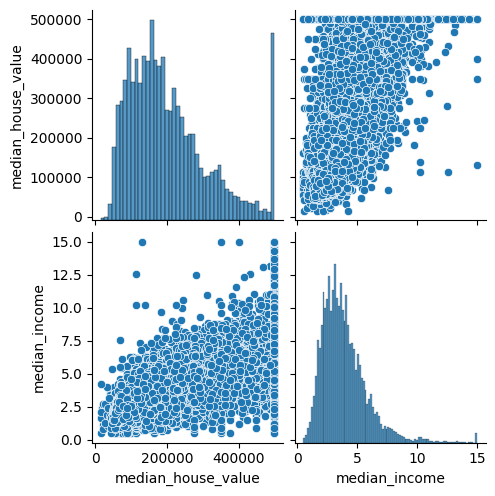

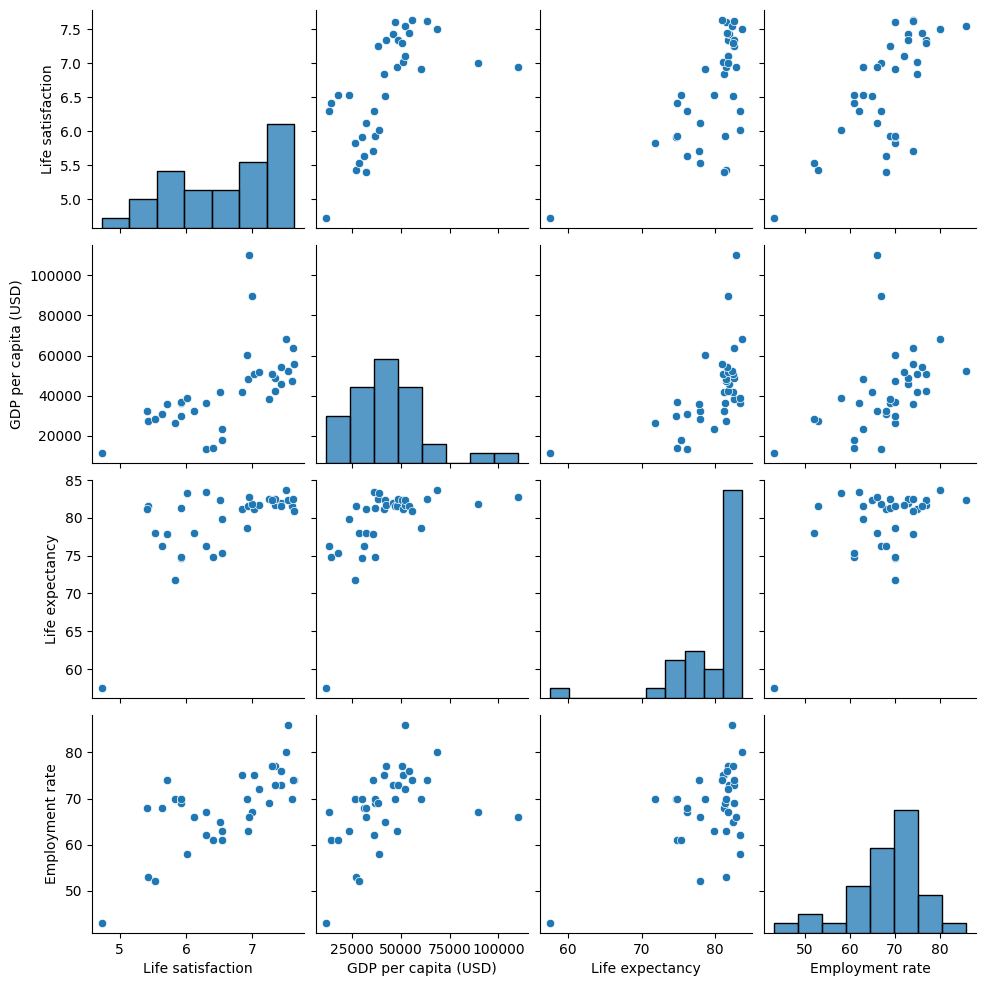

['GDP per capita (USD)', 'Life expectancy', 'Employment rate']

In [20]:
plot_features_num_regression(df_housing, target_col="median_house_value", columns=None, 
                                 umbral_corr=0.5, pvalue=None)

plot_features_num_regression(df_lifesat, target_col="Life satisfaction", columns=None, 
                                 umbral_corr=0.5, pvalue=None)

                       

In [8]:
from scipy.stats import f_oneway, kruskal


def get_features_cat_regression(df, target_col, pvalue=0.05):
    """
    Devuelve variables categóricas cuya relación con target
    sea estadísticamente significativa.

    Argumentos:
    df (pd.DataFrame)
    target_col (str)
    pvalue (float)

    Retorna:
    list
    """

    if target_col not in df.columns:
        print("Error: target_col no existe.")
        return None

    if not np.issubdtype(df[target_col].dtype, np.number):
        print("Error: target_col debe ser numérica.")
        return None

    if not (0 < pvalue < 1):
        print("Error: pvalue debe estar entre 0 y 1.")
        return None

    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    columnas_validas = []

    for col in cat_cols:
        grupos = [df[df[col] == cat][target_col].dropna() 
                  for cat in df[col].dropna().unique()]

        if len(grupos) < 2:
            continue

        try:
            stat, p_val = f_oneway(*grupos)
        except:
            stat, p_val = kruskal(*grupos)

        if p_val <= pvalue:
            columnas_validas.append(col)

    return columnas_validas


In [23]:
get_features_cat_regression(df_housing, target_col="median_house_value", pvalue=0.05)

get_features_cat_regression(df_lifesat, target_col="Life satisfaction", pvalue=0.05)

col_cat_housing = get_features_cat_regression(df_housing, target_col="median_house_value", pvalue=0.05)

col_cat_lifesat = get_features_cat_regression(df_lifesat, target_col="Life satisfaction", pvalue=0.05)

print(col_cat_housing)
print("\n\n")
print(col_cat_lifesat)

['ocean_proximity']



[]


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17324\539808254.py:41: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p_val = f_oneway(*grupos)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17324\539808254.py:41: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  st

In [9]:
def plot_features_cat_regression(df, target_col="", columns=None,
                                 pvalue=0.05, with_individual_plot=False):
    """
    Grafica histogramas del target agrupados por variables categóricas
    que sean significativas.

    Retorna:
    list
    """

    if columns is None:
        columns = []

    valid_cols = get_features_cat_regression(df, target_col, pvalue)

    if valid_cols is None:
        return None

    if columns:
        valid_cols = [col for col in columns if col in valid_cols]

    if not valid_cols:
        print("No hay variables significativas.")
        return []

    for col in valid_cols:
        plt.figure()
        sns.histplot(data=df, x=target_col, hue=col, multiple="stack")
        plt.title(f"{target_col} vs {col}")
        plt.show()

        if with_individual_plot:
            for cat in df[col].unique():
                plt.figure()
                sns.histplot(df[df[col] == cat][target_col])
                plt.title(f"{target_col} - {col}: {cat}")
                plt.show()

    return valid_cols


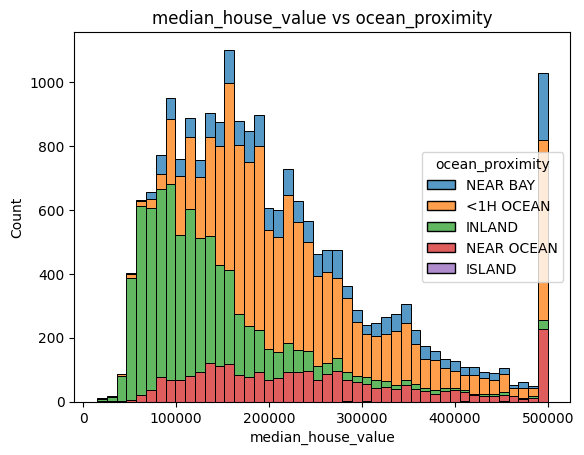

No hay variables significativas.


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17324\539808254.py:41: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p_val = f_oneway(*grupos)


[]

In [24]:
plot_features_cat_regression(df_housing, target_col="median_house_value", columns=None,
                                 pvalue=0.05, with_individual_plot=False)

plot_features_cat_regression(df_lifesat, target_col="Life satisfaction", columns=None,
                                 pvalue=0.05, with_individual_plot=False)